# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Final Project: 

## Models Notebook


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">



In [2]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import seaborn as sns
from pandas.plotting import scatter_matrix


pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 
from sklearn.utils import shuffle
import tensorflow as tf

from sklearn import tree
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


# TODO remove before submitting
import warnings
warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'tensorflow'

</span></div><div class='alert alert-block alert-danger'><b>Linear Models:</b><span style = 'color:black'> </span></div></div>

# Classification


In [2]:
#read in data
songs_df = pd.read_csv('data/songs_all_decade.csv')
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

#songs_df_clean.head()

In [3]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, train_size = 0.8, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)

---

In [4]:
#standardize data
cat_cols = ['Key', 'Time Signature']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

In [5]:
#X_train.head()
#X_test.head()

### Simple OLS

In [6]:
#simple linear regression classification
OLSmodel = LinearRegression().fit(X_train, y_train.values)

y_hat_train = OLSmodel.predict(X_train)
y_hat_test = OLSmodel.predict(X_test).astype(int)

train_score = accuracy_score(y_train, np.round(y_hat_train))*100
test_score = accuracy_score(y_test, np.round(y_hat_test))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)

Train accuracy: 82.69123705600713
Test accuracy: 82.7135062910589


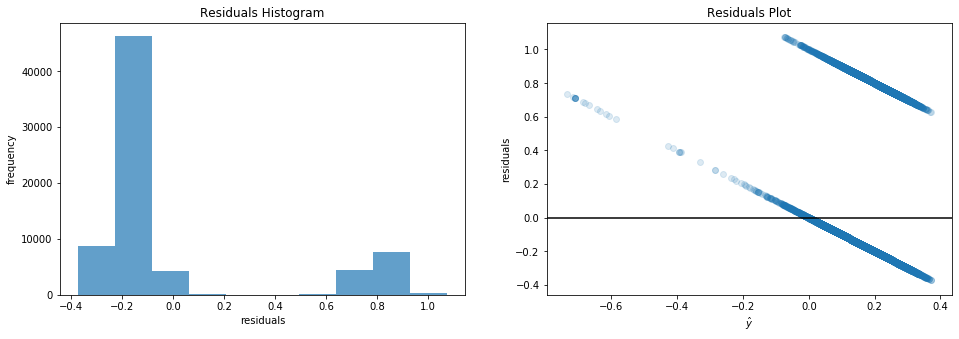

In [7]:
#residual plots
residuals = y_train - y_hat_train

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax = ax.ravel()

ax[0].hist(residuals, alpha=0.7)
ax[0].set_title('Residuals Histogram')
ax[0].set_xlabel('residuals')
ax[0].set_ylabel('frequency')

ax[1].set_title('Residuals Plot')
ax[1].scatter(y_hat_train, residuals, alpha=0.15)
ax[1].set_xlabel(r'$\hat{y}$')
ax[1].set_ylabel('residuals')
ax[1].axhline(0, color='k');

### Add interaction terms

In [8]:
# #try using interaction terms but get error

# keys = X_train.columns[X_train.columns.str.startswith('Key')]
# time_sigs = X_train.columns[X_train.columns.str.startswith('Time')]

# def interactions(dframe, dummies=[keys, time_sigs], conts = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
#                                                                        'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
#                                                                        'Speechiness', 'Tempo', 'Valence']): 
#     df = dframe.copy()
#     for cont in conts:
#         for dummy in dummies:
#             df['{}*{}'.format(cont, dummy)] = dframe[cont]*dframe[dummy]
#     return df

# #train polynomial model with interactions
# x_int_train = interactions(X_train)
# x_int_test = interactions(X_test)

### Add polynomial terms

In [9]:
#polynomial regression
def higher_order(dframe, degree, cols = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
                                           'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
                                           'Speechiness', 'Tempo', 'Valence']): 
    for col in cols:
        for i in range(2, degree+1):
            dframe['{}^{}'.format(col, i)] = dframe[col]**i
    return dframe

x_poly_train = higher_order(X_train, 10)
x_poly_test = higher_order(X_test, 10)

#train model
model = LinearRegression()
model.fit(x_poly_train, y_train)

y_poly_pred_train = model.predict(x_poly_train)
y_poly_pred_test = model.predict(x_poly_test)

train_score = accuracy_score(y_train, np.round(y_poly_pred_train))*100
test_score = accuracy_score(y_test, np.round(y_poly_pred_test))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)

Train accuracy: 82.70793898229596
Test accuracy: 82.7135062910589


### Ridge Model

In [10]:
alphas = [.1,.5,1,5,10,50,100, 1000, 100000]

#ridge model
ridge_model = RidgeCV(alphas=alphas).fit(X_train, y_train)
best_ridge = ridge_model.alpha_
print(f'Best regularization level for ridge regression: {best_ridge}')
y_ridge_pred_train = ridge_model.predict(X_train)
y_ridge_pred_test = ridge_model.predict(X_test)

train_score = accuracy_score(y_train, np.round(y_ridge_pred_train))*100
test_score = accuracy_score(y_test, np.round(y_ridge_pred_test))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print('number of predictors:', len(ridge_model.coef_))


#ridge model for polynomials
ridge_model = RidgeCV(alphas=alphas).fit(x_poly_train, y_train)
best_ridge = ridge_model.alpha_
print(f'Best regularization level for ridge regression: {best_ridge}')
y_ridge_pred_train_poly = ridge_model.predict(x_poly_train)
y_ridge_pred_test_poly = ridge_model.predict(x_poly_test)

train_score = accuracy_score(y_train, np.round(y_ridge_pred_train_poly))*100
test_score = accuracy_score(y_test, np.round(y_ridge_pred_test_poly))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print('number of predictors:', len(ridge_model.coef_))


Best regularization level for ridge regression: 0.1
Train accuracy: 82.71211446386818
Test accuracy: 82.70793898229596
number of predictors: 127
Best regularization level for ridge regression: 0.1
Train accuracy: 82.71211446386818
Test accuracy: 82.70793898229596
number of predictors: 127


### Lasso Model

In [11]:
#lasso model
lasso_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)
best_lasso = lasso_model.alpha_
print(f'Best regularization level for lasso regression: {best_lasso}')
y_lasso_pred_train = lasso_model.predict(X_train)
y_lasso_pred_test = lasso_model.predict(X_test)

train_score = accuracy_score(y_train, np.round(y_lasso_pred_train))*100
test_score = accuracy_score(y_test, np.round(y_lasso_pred_test))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print('number of predictors:', len(lasso_model.coef_))

#lasso for polynomial terms
lasso_model1 = LassoCV(alphas=alphas, max_iter=100000).fit(x_poly_train, y_train)
best_lasso1 = lasso_model1.alpha_
print(f'Best regularization level for lasso regression: {best_lasso1}')
y_lasso_pred_train_poly = lasso_model1.predict(x_poly_train)
y_lasso_pred_test_poly = lasso_model1.predict(x_poly_test)

train_score = accuracy_score(y_train, np.round(y_lasso_pred_train_poly))*100
test_score = accuracy_score(y_test, np.round(y_lasso_pred_test_poly))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print('number of predictors:',len(lasso_model1.coef_))

Best regularization level for lasso regression: 100000.0
Train accuracy: 82.7135062910589
Test accuracy: 82.7135062910589
number of predictors: 127
Best regularization level for lasso regression: 100000.0
Train accuracy: 82.7135062910589
Test accuracy: 82.7135062910589
number of predictors: 127


### Plot Coefficients

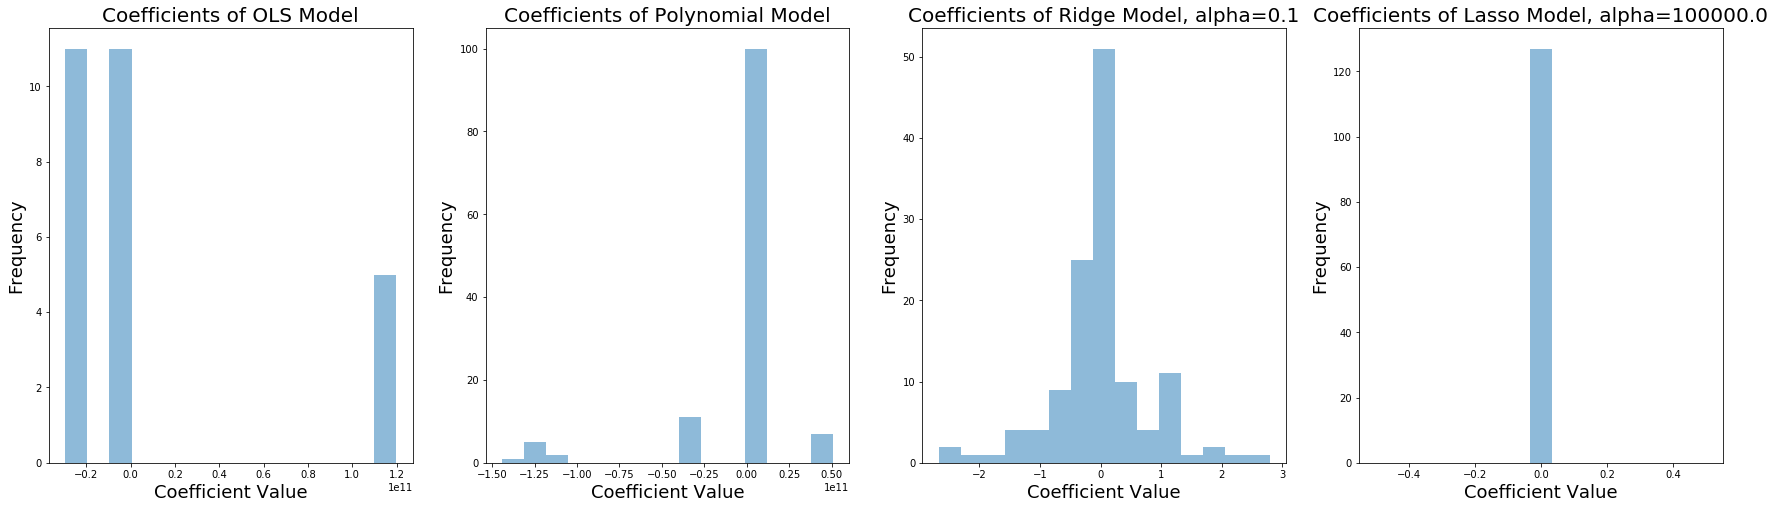

In [12]:
fig, ax = plt.subplots(figsize=(30,8), ncols=4)
ax = ax.ravel()

ax[0].hist(OLSmodel.coef_[1:], bins=15, alpha=0.5)
ax[0].set_title('Coefficients of OLS Model', fontsize=20)
ax[0].set_xlabel('Coefficient Value', fontsize=18)
ax[0].set_ylabel('Frequency', fontsize=18)

ax[1].hist(model.coef_[1:], bins=15, alpha=0.5)
ax[1].set_title('Coefficients of Polynomial Model', fontsize=20)
ax[1].set_xlabel('Coefficient Value', fontsize=18)
ax[1].set_ylabel('Frequency', fontsize=18)

ax[2].hist(ridge_model.coef_.flatten(), bins=15, alpha=0.5)
ax[2].set_title(f'Coefficients of Ridge Model, alpha={best_ridge}', fontsize=20)
ax[2].set_xlabel('Coefficient Value', fontsize=18)
ax[2].set_ylabel('Frequency', fontsize=18)

ax[3].hist(lasso_model.coef_.flatten(), bins=15, alpha=0.5)
ax[3].set_title(f'Coefficients of Lasso Model, alpha={best_lasso}', fontsize=20)
ax[3].set_xlabel('Coefficient Value', fontsize=18)
ax[3].set_ylabel('Frequency', fontsize=18);

fig.savefig('coefhist.png')

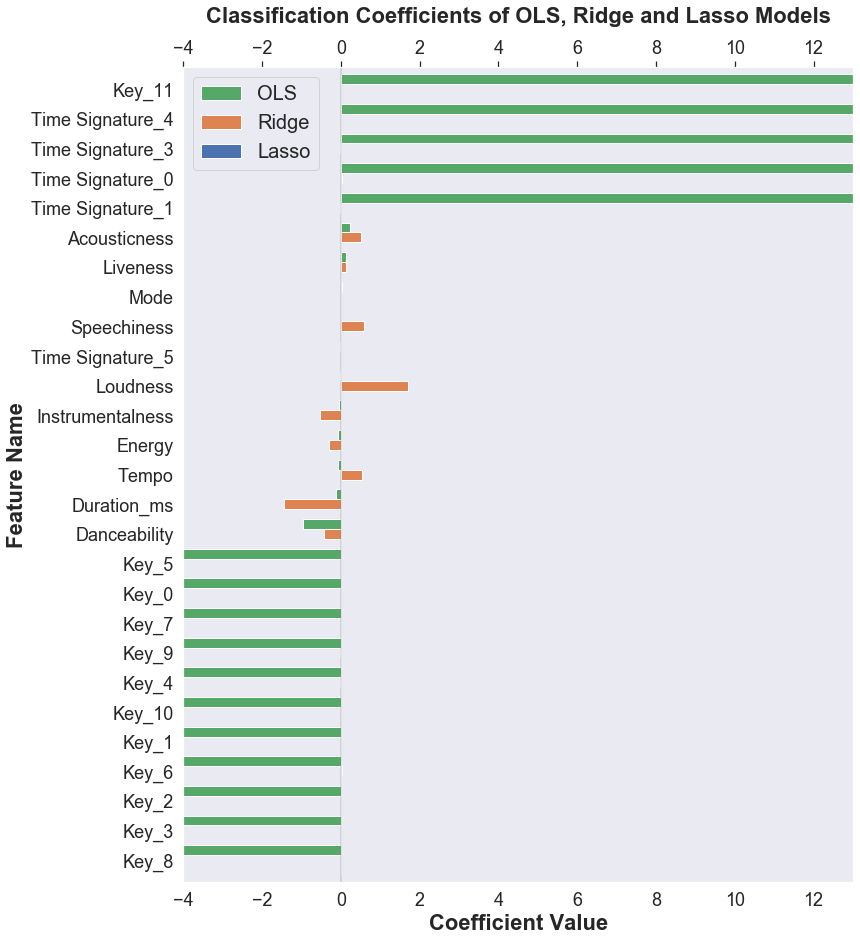

In [13]:
# outside sources: https://stackoverflow.com/questions/15201386/how-to-plot-multiple-horizontal-bars-in-one-chart-with-matplotlib
# also: https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list

OLS_vals = OLSmodel.coef_[1:]
order = OLS_vals.argsort()
OLS_vals = OLS_vals[order]

lasso_vals = lasso_model.coef_.flatten()[order]
ridge_vals = ridge_model.coef_.flatten()[order]

features = X_train.columns[order]

sns.set(style='dark', context='notebook')
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

df = pd.DataFrame({'Lasso': lasso_vals, 'Ridge': ridge_vals, 'OLS': OLS_vals}, index=features)
ax = df.plot.barh(figsize=(12,15), width=1)

# outside source: https://mode.com/example-gallery/python_horizontal_bar/
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, alpha=0.3, color='gray')

ax.set_xlabel('Coefficient Value', fontsize=22, fontweight='bold')
ax.set_ylabel('Feature Name', fontsize=22, fontweight='bold')
ax.set_xlim(-4, 13)

# outside source: https://matplotlib.org/1.3.1/users/legend_guide.html
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=20)

ax.tick_params(labelsize=18)
ax.set_title('Classification Coefficients of OLS, Ridge and Lasso Models', fontsize=22, pad=44, fontweight='bold');

fig = ax.get_figure()
fig.savefig("coef.png") 

---

## Regression




In [14]:
#read in data
songs_df = pd.read_csv('data/songs_all_decade.csv')
songs_df_clean2 = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

#songs_df_clean2.head()

In [15]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(songs_df_clean2.loc[:, songs_df_clean2.columns != 'Popularity'], 
                                                    songs_df_clean2.Popularity, train_size = 0.8, 
                                                    random_state = 100)

In [16]:
#standardize data
cat_cols = ['Key', 'Time Signature']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

In [17]:
#X_train.head()
#X_test.head()

### Simple OLS

In [18]:
#simple linear regression
OLSmodel = LinearRegression().fit(X_train, y_train)

y_hat_train = OLSmodel.predict(X_train)
y_hat_test = OLSmodel.predict(X_test)

print('Train R^2 = {:.4}'.format(r2_score(y_train, y_hat_train)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, y_hat_test)))

Train R^2 = 0.09597
Test R^2 = 0.09553


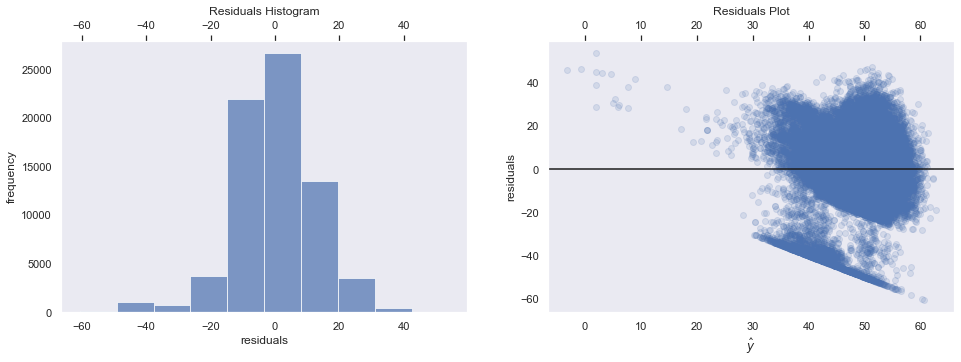

In [19]:
#residual plots
residuals = y_train - y_hat_train

fig, ax = plt.subplots(1,2, figsize=(16,5))
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
ax = ax.ravel()

ax[0].hist(residuals, alpha=0.7)
ax[0].set_title('Residuals Histogram')
ax[0].set_xlabel('residuals')
ax[0].set_ylabel('frequency')

ax[1].set_title('Residuals Plot')
ax[1].scatter(y_hat_train, residuals, alpha=0.15)
ax[1].set_xlabel(r'$\hat{y}$')
ax[1].set_ylabel('residuals')
ax[1].axhline(0, color='k');

fig.savefig('residual_plots.png')

### Add interaction terms

In [20]:
# #try using interaction terms but get error

# keys = X_train.columns[X_train.columns.str.startswith('Key')]
# time_sigs = X_train.columns[X_train.columns.str.startswith('Time')]

# def interactions(dframe, dummies=[keys, time_sigs], conts = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
#                                                                        'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
#                                                                        'Speechiness', 'Tempo', 'Valence']): 
#     df = dframe.copy()
#     for cont in conts:
#         for dummy in dummies:
#             df['{}*{}'.format(cont, dummy)] = dframe[cont]*dframe[dummy]
#     return df

# #train polynomial model with interactions
# x_int_train = interactions(X_train)
# x_int_test = interactions(X_test)

### Add polynomial terms

In [21]:
#polynomial regression
def higher_order(dframe, degree, cols = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
                                           'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
                                           'Speechiness', 'Tempo', 'Valence']): 
    df = dframe.copy()
    for col in cols:
        for i in range(2, degree+1):
            df['{}^{}'.format(col, i)] = dframe[col]**i
    return df

#train polynomial model
x_poly_train = higher_order(X_train, 2)
x_poly_test = higher_order(X_test, 2)

model = LinearRegression()
model.fit(x_poly_train, y_train)

y_poly_pred_train = model.predict(x_poly_train)
y_poly_pred_test = model.predict(x_poly_test)

print('Poly Train R^2 = {:.4}'.format(r2_score(y_train, y_poly_pred_train)))
print('Poly Test R^2 = {:.4}'.format(r2_score(y_test, y_poly_pred_test)))

Poly Train R^2 = 0.1256
Poly Test R^2 = 0.1193


### Ridge Model

In [22]:
#ridge model
alphas = [.1,.5,1,5,10,50,100, 1000, 100000]

ridge_model = RidgeCV(alphas=alphas).fit(X_train, y_train)
best_ridge = ridge_model.alpha_
print(f'Best regularization level for ridge regression: {best_ridge}')
y_ridge_pred_train = ridge_model.predict(X_train)
y_ridge_pred_test = ridge_model.predict(X_test)

print('Train R^2 = {:.4}'.format(r2_score(y_train, y_ridge_pred_train)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, y_ridge_pred_test)))

ridge_model1 = RidgeCV(alphas=alphas).fit(x_poly_train, y_train)
best_ridge = ridge_model1.alpha_
print(f'Best regularization level for ridge regression: {best_ridge}')
y_ridge_pred_train_poly = ridge_model1.predict(x_poly_train)
y_ridge_pred_test_poly = ridge_model1.predict(x_poly_test)

print('Poly Train R^2 = {:.4}'.format(r2_score(y_train, y_ridge_pred_train_poly)))
print('Poly Test R^2 = {:.4}'.format(r2_score(y_test, y_ridge_pred_test_poly)))

Best regularization level for ridge regression: 1.0
Train R^2 = 0.096
Test R^2 = 0.0956
Best regularization level for ridge regression: 0.1
Poly Train R^2 = 0.1256
Poly Test R^2 = 0.1193


### Lasso Model

In [23]:
#lasso model
lasso_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)
best_lasso = lasso_model.alpha_
print(f'Best regularization level for lasso regression: {best_lasso}')
y_lasso_pred_train = lasso_model.predict(X_train)
y_lasso_pred_test = lasso_model.predict(X_test)

print('Train R^2 = {:.4}'.format(r2_score(y_train, y_lasso_pred_train)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, y_lasso_pred_test)))
print('number of predictors:', len(lasso_model.coef_))



lasso_model1 = LassoCV(alphas=alphas, max_iter=100000).fit(x_poly_train, y_train)
best_lasso = lasso_model1.alpha_
print(f'Best regularization level for lasso regression: {best_lasso}')
y_lasso_pred_train_poly = lasso_model1.predict(x_poly_train)
y_lasso_pred_test_poly = lasso_model1.predict(x_poly_test)

print('Poly Train R^2 = {:.4}'.format(r2_score(y_train, y_ridge_pred_train_poly)))
print('Poly Test R^2 = {:.4}'.format(r2_score(y_test, y_ridge_pred_test_poly)))
print('number of predictors:', len(lasso_model1.coef_))


Best regularization level for lasso regression: 0.1
Train R^2 = 0.06887
Test R^2 = 0.06609
number of predictors: 28
Best regularization level for lasso regression: 0.1
Poly Train R^2 = 0.1256
Poly Test R^2 = 0.1193
number of predictors: 39


### Plot Coefficients

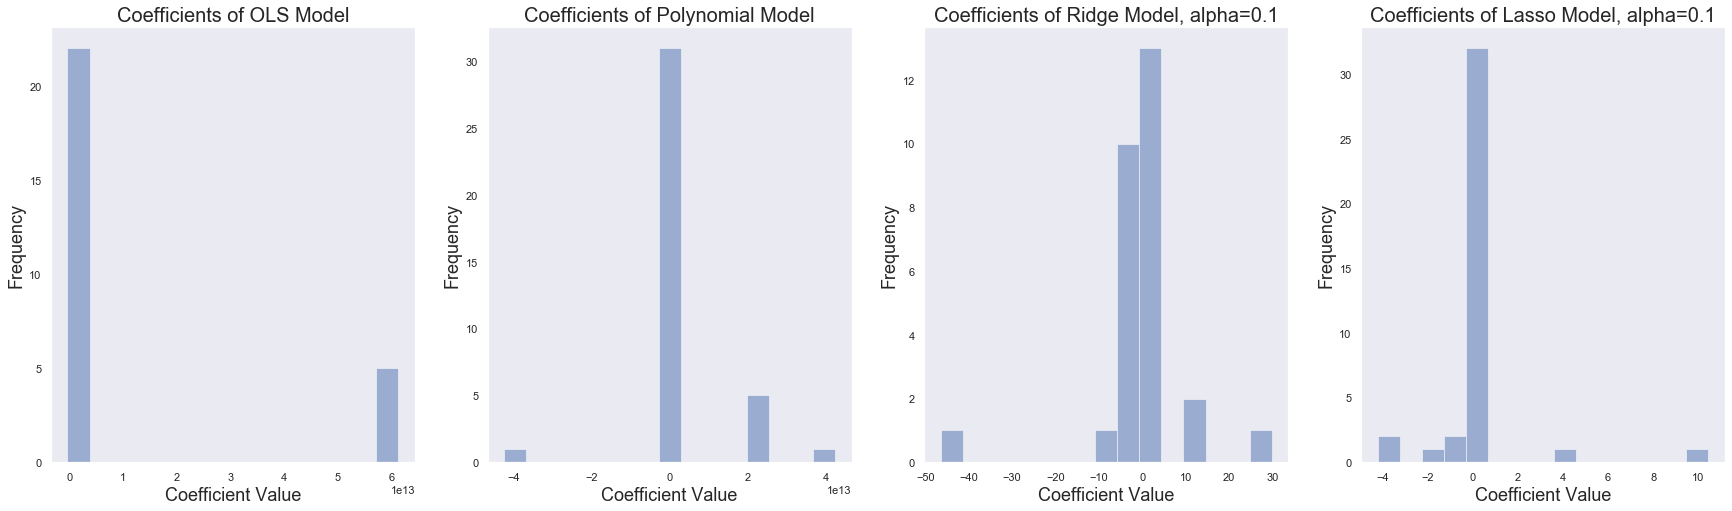

In [24]:
fig, ax = plt.subplots(figsize=(30,8), ncols=4)
ax = ax.ravel()

ax[0].hist(OLSmodel.coef_[1:], bins=15, alpha=0.5)
ax[0].set_title('Coefficients of OLS Model', fontsize=20)
ax[0].set_xlabel('Coefficient Value', fontsize=18)
ax[0].set_ylabel('Frequency', fontsize=18)

ax[1].hist(model.coef_[1:], bins=15, alpha=0.5)
ax[1].set_title('Coefficients of Polynomial Model', fontsize=20)
ax[1].set_xlabel('Coefficient Value', fontsize=18)
ax[1].set_ylabel('Frequency', fontsize=18)

ax[2].hist(ridge_model.coef_.flatten(), bins=15, alpha=0.5)
ax[2].set_title(f'Coefficients of Ridge Model, alpha={best_ridge}', fontsize=20)
ax[2].set_xlabel('Coefficient Value', fontsize=18)
ax[2].set_ylabel('Frequency', fontsize=18)

ax[3].hist(lasso_model1.coef_.flatten(), bins=15, alpha=0.5)
ax[3].set_title(f'Coefficients of Lasso Model, alpha={best_lasso}', fontsize=20)
ax[3].set_xlabel('Coefficient Value', fontsize=18)
ax[3].set_ylabel('Frequency', fontsize=18);

fig.savefig('coefhist2.png')

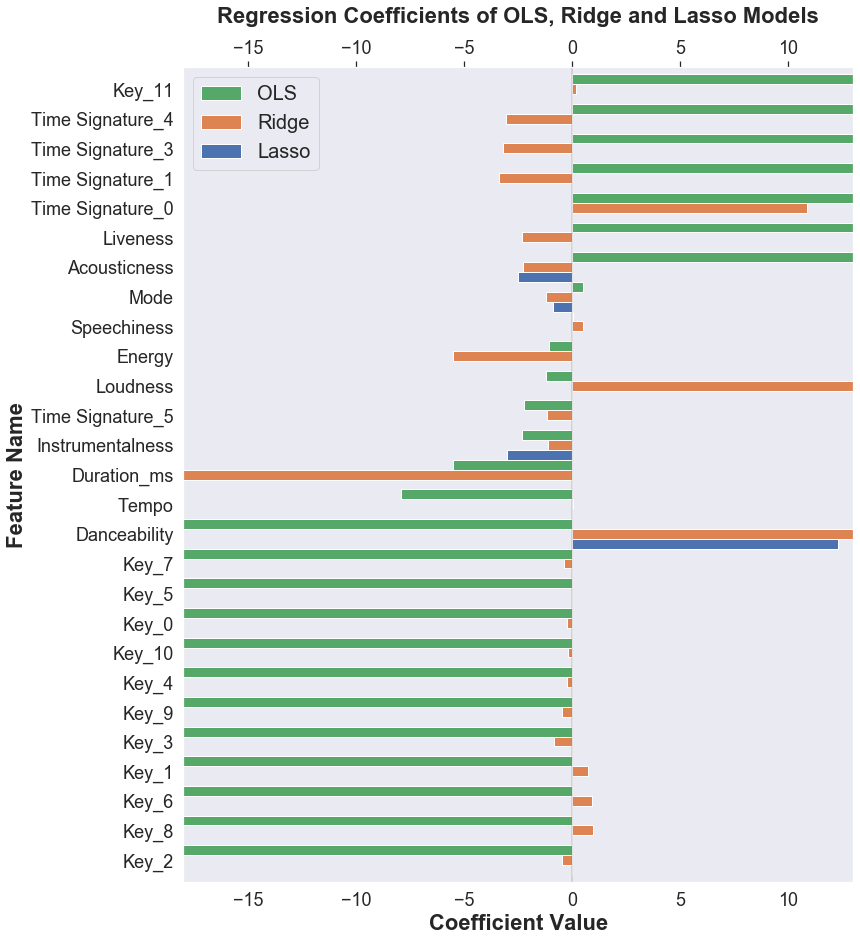

In [25]:
# outside sources: https://stackoverflow.com/questions/15201386/how-to-plot-multiple-horizontal-bars-in-one-chart-with-matplotlib
# also: https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list

OLS_vals = OLSmodel.coef_[1:]
order = OLS_vals.argsort()
OLS_vals = OLS_vals[order]

lasso_vals = lasso_model.coef_.flatten()[order]
ridge_vals = ridge_model.coef_.flatten()[order]

features = X_train.columns[order]

sns.set(style='dark', context='notebook')
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

df = pd.DataFrame({'Lasso': lasso_vals, 'Ridge': ridge_vals, 'OLS': OLS_vals}, index=features)
ax = df.plot.barh(figsize=(12,15), width=1)

# outside source: https://mode.com/example-gallery/python_horizontal_bar/
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, alpha=0.3, color='gray')

ax.set_xlabel('Coefficient Value', fontsize=22, fontweight='bold')
ax.set_ylabel('Feature Name', fontsize=22, fontweight='bold')
ax.set_xlim(-18, 13)

# outside source: https://matplotlib.org/1.3.1/users/legend_guide.html
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=20)

ax.tick_params(labelsize=18)
ax.set_title('Regression Coefficients of OLS, Ridge and Lasso Models', fontsize=22, pad=44, fontweight='bold');

fig = ax.get_figure()
fig.savefig("coef2.png") 


</span></div><div class='alert alert-block alert-danger'><b>Hi</b><span style = 'color:black'> </span></div></div>

In [ ]:
songs_df = pd.read_csv('data/songs_all_decade_clean.csv')

songs_df.head()

In [ ]:
# matrix of pairwise scatterplots
scatter_matrix(songs_df, alpha = 0.8, figsize = (30, 20), diagonal = 'kde')

# TREE + ENSEMBLE METHODS

## Classification

In [ ]:
# classify as top hit if popularity > 60 (about halfway split)
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)


In [ ]:
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)



#### SINGLE TREE

In [ ]:
# fit cross-validated single decision tree
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        model = DecisionTreeClassifier(max_depth = i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        # get training set scores
        train_scores[i] = accuracy_score(y_train, y_pred)
        # get cross-validation scores
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

In [ ]:
# report best tree depth from cross-validation
best_depth = sorted(cvmeans, key = cvmeans.get, reverse = True)[0]
print('Best depth:', best_depth)

# refit on best tree depth, then report classification accuracies
best_model = DecisionTreeClassifier(max_depth = best_depth)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
best_cv_tree_train_score = accuracy_score(y_train, y_train_pred)
print('Classification accuracy on training set:', best_cv_tree_train_score)

y_test_pred = best_model.predict(X_test)
best_cv_tree_test_score = accuracy_score(y_test, y_test_pred)
print('Classification accuracy on test set:', best_cv_tree_test_score)

In [ ]:
fitted_bag = BaggingClassifier(n_estimators=50, random_state=0).fit(X_train,y_train)
bag_train_score = fitted_bag.score(X_train, y_train)
bag_test_score = fitted_bag.score(X_test, y_test)


print('Classification accuracy on training set:', bag_train_score)
print('Classification accuracy on test set:', bag_test_score)

#### BAGGING

In [ ]:
fitted_bag = BaggingClassifier(n_estimators=50, random_state=0).fit(X_train,y_train)
bag_train_score = fitted_bag.score(X_train, y_train)
bag_test_score = fitted_bag.score(X_test, y_test)


print('Classification accuracy on training set:', bag_train_score)
print('Classification accuracy on test set:', bag_test_score)

#### RANDOM FOREST

In [ ]:
fitted_rf = RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=10).fit(X_train,y_train)
random_forest_train_score = fitted_rf.score(X_train, y_train)
random_forest_test_score = fitted_rf.score(X_test, y_test)


print('Classification accuracy on training set:', random_forest_train_score)
print('Classification accuracy on test set:', random_forest_test_score)


In [ ]:
clfs = {}
train_scores = {}
test_scores = {}
for depth in (1,2,3,4):
    fitted_ada = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth),
        n_estimators=800,
        learning_rate=.05).fit(X_train, y_train)
    train_scores[depth] = list(fitted_ada.staged_score(X_train, y_train))
    test_scores[depth] = list(fitted_ada.staged_score(X_test, y_test))
    clfs[depth] = fitted_ada

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20,10), sharey=True)
for ax, depth in zip(axs, (1,2,3,4)):
    ax.plot(train_scores[depth], label='train')
    ax.plot(test_scores[depth], label='test')
    ax.set(xlabel='Iteration', ylabel='Accuracy', title=f"max_depth={depth}")
    ax.legend()
plt.suptitle("Accuracy of AdaBoost as Training Progresses");

In [ ]:
best_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=250,
        learning_rate=.05).fit(X_train, y_train)
best_ada_train_score = best_ada.score(X_train, y_train)
best_ada_test_score = best_ada.score(X_test, y_test)



In [ ]:
print('Classification accuracy on training set:', best_ada_train_score)
print('Classification accuracy on test set:', best_ada_test_score)

## Regression

In [ ]:
songs_df_clean2 = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(songs_df_clean2.loc[:, songs_df_clean.columns != 'Popularity'], 
                                                    songs_df_clean2.Popularity, test_size = 0.2, 
                                                    random_state = 100)

#### SINGLE TREE

In [ ]:
tree_reg = DecisionTreeRegressor(criterion='mse', splitter='best').fit(X_train_2, y_train_2)

tree_reg_train_score = tree_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', tree_reg_train_score)


tree_reg_test_score = tree_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', tree_reg_test_score)


#### BAGGING

In [ ]:
bag_reg = BaggingRegressor(n_estimators=10, random_state=0).fit(X_train_2, y_train_2)

bag_reg_train_score = bag_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', bag_reg_train_score)

bag_reg_test_score = bag_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', bag_reg_test_score)

#### RANDOM FOREST

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=100, criterion='mse').fit(X_train_2, y_train_2)

rf_reg_train_score = rf_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', rf_reg_train_score)

rf_reg_test_score = rf_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', rf_reg_test_score)



#### BOOSTING

In [ ]:
boost_reg = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100).fit(X_train_2, y_train_2)

boost_reg_train_score = boost_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', boost_reg_train_score)

boost_reg_test_score = boost_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', boost_reg_test_score)

# LOGISTIC

In [ ]:
logit = LogisticRegressionCV( solver='liblinear', penalty='l1', multiclass='ovr', cv=5)
logit.fit(X_train, y_train)

log_y_train_pred = logit.predict(X_train) 
log_y_test_pred = logit.predict(X_test)

log_train_score = accuracy_score(y_train, log_y_train_pred)
log_test_score = accuracy_score(y_test, log_y_test_pred)

print('Penalty: LASSO')
print('Classification accuracy on training set:', log_train_score)
print('Classification accuracy on test set:', log_test_score)

# k-NN

In [ ]:
ks = [1,2,3,4,5,7,9,10,15,25]

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': ks}
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(X_train, y_train)

y_train_knn = knn_gscv.predict(X_train)
y_test_knn = knn_gscv.predict(X_test)

In [2]:
print('Best k:', list(knn_gscv.best_params_.values())[0])

print('Classification accuracy on training set:', accuracy_score(y_train, y_train_knn))
print('Classification accuracy on test set:', accuracy_score(y_test, y_test_knn))

</span></div><div class='alert alert-block alert-danger'><b>Neural Networks:</b><span style = 'color:black'> </span></div></div>

In [ ]:
# read in all songs
songs_df = pd.read_csv('data/songs_all_decade_clean.csv')
songs_df.head()

In [ ]:
# create new binary response variable 'tophit'
# classify as top hit if popularity > 60 (about halfway split)
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)

In [ ]:
# prepare for modeling
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)

In [ ]:
cat_cols = ['Key', 'Time Signature', 'Mode']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)
X_train_dum = X_train[cat_cols]
X_test_dum = X_test[cat_cols]

scaler = StandardScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

In [ ]:
X_train.head()

In [ ]:
# specify network layers
binary_ann_overfit = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile and fit network
binary_ann_overfit.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann_overfit.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

In [ ]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [ ]:
print(binary_ann_overfit.evaluate(X_train, y_train, verbose=0))
print(binary_ann_overfit.evaluate(X_test, y_test, verbose=0))

In [ ]:
# address overfitting
binary_ann = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu', 
                       kernel_regularizer = tf.keras.regularizers.l2(l = 0.001)),
    tf.keras.layers.Dense(100, activation = 'relu', 
                       kernel_regularizer = tf.keras.regularizers.l2(l = 0.001)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile and fit network
binary_ann.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

In [ ]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [ ]:
binary_ann.evaluate(X_train, y_train, verbose=0) 

In [ ]:
songs_df = pd.read_csv('data/songs_all_decade_clean.csv')

songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'Popularity'], 
                                                    songs_df_clean.Popularity, test_size = 0.2, 
                                                    random_state = 100)

In [ ]:
# cat_cols = ['Key', 'Time Signature']
# X_train_num = X_train.drop(cat_cols, axis = 1)
# X_test_num = X_test.drop(cat_cols, axis = 1)
# num_features = X_train_num.columns.tolist()
# num_index_train = X_train.index.tolist()
# num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

# scaler = MinMaxScaler().fit(X_train_num)
# X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

# X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
# X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

cat_cols = ['Key', 'Time Signature', 'Mode']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)
X_train_dum = X_train[cat_cols]
X_test_dum = X_test[cat_cols]

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

In [ ]:
# quantitative: ANN
# specify network layers
quant_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = 'sigmoid', input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
     tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
])

# compile and fit network
quant_ann.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_squared_error']) 
history = quant_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

In [ ]:
# plot training and validation accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE vs. Epochs')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [ ]:
scores = quant_ann.predict(X_test)
accuracy = r2_score(y_test, scores)
print(accuracy)

In [ ]:
# quantitative: ANN
# specify network layers
quant_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = 'sigmoid', input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu', 
                       kernel_regularizer = tf.keras.regularizers.l2(l = 0.001)),
    tf.keras.layers.Dense(1, activation = 'linear')
])

# compile and fit network
quant_ann.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_squared_error']) 
history = quant_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

In [ ]:
# plot training and validation accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE vs. Epochs')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [ ]:
from sklearn.metrics import r2_score

scores = quant_ann.predict(X_train)
accuracy = r2_score(y_train, scores)
print(accuracy)